In [1]:
import torch

print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

12.8
NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
allocated_bytes = torch.cuda.memory_allocated('cuda')
allocated_mb = allocated_bytes / (1024 * 1024)

reserved_bytes = torch.cuda.memory_reserved('cuda')
reserved_mb = reserved_bytes / (1024 * 1024)

print("\n--- VRAM USAGE REPORT ---")
print(f"Memory Allocated: {allocated_mb:.2f} MB")
print(f"Memory Reserved:  {reserved_mb:.2f} MB")
print("-------------------------\n")


--- VRAM USAGE REPORT ---
Memory Allocated: 0.00 MB
Memory Reserved:  0.00 MB
-------------------------



In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

validation_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

basic_pipeline = A.Compose([
    # Resize the image first
    A.Resize(height=224, width=224),
    A.RandomCrop(height=180, width=180, p=0.7),
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.6),
    A.Rotate(limit=(-45,45), p=0.7),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [4]:
import torch.nn as nn
from torchvision import models

class PestClassifierResNet50(nn.Module):

    def __init__(self, num_classes):

        super(PestClassifierResNet50,self).__init__()

        self.base_model = models.resnet50(weights=None)

        features = self.base_model.fc.in_features

        self.base_model.fc = nn.Sequential(
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(features, num_classes),
        )

    def forward(self, x):

        return self.base_model(x)

In [7]:
import torch
from tqdm import tqdm
import time

def train_and_validate(model, optimizer, criterion, train_dataloader, validation_dataloader, num_epoch, device):

    total_time = 0.0
    train_losses = []
    validation_losses = []
    accuracies = []
    best_validation_loss=float('inf')

    start_time = time.time()

    for epoch in range(num_epoch):
        model.train()
        running_train_loss = 0.0
        train_pbar = tqdm(train_dataloader, desc=f"Train epoch: {epoch+1}")
        for data, labels in train_pbar:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        training_loss = running_train_loss / len(train_dataloader)
        train_losses.append(training_loss)

        model.eval()
        running_eval_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(validation_dataloader, desc=f"Validate Epoch {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)

                logits = model(inputs)
                loss = criterion(logits, labels)
                running_eval_loss += loss.item()
                _, predicted = torch.max(logits.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        validation_loss = running_eval_loss / len(validation_dataloader)
        validation_losses.append(validation_loss)
        accuracy = 100 * correct_predictions / total_samples
        accuracies.append(accuracy)

        epoch_summary = f'Epoch {epoch+1}/{num_epoch} | Train Loss: {training_loss:.4f} | Evaluate Loss: {validation_loss:.4f} | Accuracy: {accuracy:.2f}%'

        if device.type == 'cuda':
            allocated_gb = torch.cuda.memory_allocated() / (1024 ** 3)
            reserved_gb = torch.cuda.memory_reserved() / (1024 ** 3)
            epoch_summary += f' | GPU Memory (Alloc/Reserved): {allocated_gb:.2f}/{reserved_gb:.2f} GB'

        if validation_loss < best_validation_loss - 0.001:

            best_validation_loss = validation_loss
            torch.save(model.state_dict(), 'MobileNetv2_result/models/model1.pt')

        tqdm.write(epoch_summary)

        end_time = time.time()
        total_time = end_time - start_time

    return  {'train_loss': train_losses, 'validation_loss': validation_losses, 'accuracy': accuracies}, total_time

In [8]:
from torch.utils.data import DataLoader
from helpers import CustomDataset, plot_training_result, plot_accuracy, save_historical_data

train_set = CustomDataset(root='datasets/train', transform=basic_pipeline)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
validation_set = CustomDataset(root='datasets/val', transform=validation_pipeline)
validation_loader = DataLoader(validation_set, batch_size=16, shuffle=True)
test_set = CustomDataset(root='datasets/test', transform=validation_pipeline)
test_loader = DataLoader(test_set, batch_size=16, shuffle=True)

classes = train_set.classes

<h2> Hyper parameter tuning</h2>

Validate Epoch 1: 100%|██████████| 169/169 [00:10<00:00, 16.59it/s]


Epoch 1/16 | Train Loss: 1.5977 | Evaluate Loss: 1.5127 | Accuracy: 41.09% | GPU Memory (Alloc/Reserved): 0.87/3.82 GB


Validate Epoch 2: 100%|██████████| 169/169 [00:10<00:00, 16.17it/s]


Epoch 2/16 | Train Loss: 1.4609 | Evaluate Loss: 1.4289 | Accuracy: 43.34% | GPU Memory (Alloc/Reserved): 0.87/3.82 GB


Validate Epoch 3: 100%|██████████| 169/169 [00:10<00:00, 16.37it/s]


Epoch 3/16 | Train Loss: 1.3785 | Evaluate Loss: 1.2819 | Accuracy: 51.22% | GPU Memory (Alloc/Reserved): 0.87/3.82 GB


Validate Epoch 4: 100%|██████████| 169/169 [00:21<00:00,  7.68it/s]


Epoch 4/16 | Train Loss: 1.2759 | Evaluate Loss: 1.1635 | Accuracy: 56.03% | GPU Memory (Alloc/Reserved): 0.87/3.82 GB


Validate Epoch 5: 100%|██████████| 169/169 [00:23<00:00,  7.20it/s]


Epoch 5/16 | Train Loss: 1.1968 | Evaluate Loss: 1.1989 | Accuracy: 55.55% | GPU Memory (Alloc/Reserved): 0.87/3.82 GB


Validate Epoch 6: 100%|██████████| 169/169 [00:19<00:00,  8.47it/s]


Epoch 6/16 | Train Loss: 1.1410 | Evaluate Loss: 1.0477 | Accuracy: 62.20% | GPU Memory (Alloc/Reserved): 0.87/3.82 GB


Validate Epoch 7: 100%|██████████| 169/169 [00:12<00:00, 13.87it/s]


Epoch 7/16 | Train Loss: 1.0809 | Evaluate Loss: 0.9730 | Accuracy: 64.24% | GPU Memory (Alloc/Reserved): 0.87/3.82 GB


Validate Epoch 8: 100%|██████████| 169/169 [00:10<00:00, 16.72it/s]


Epoch 8/16 | Train Loss: 1.0152 | Evaluate Loss: 1.0088 | Accuracy: 61.80% | GPU Memory (Alloc/Reserved): 0.87/3.82 GB


Validate Epoch 9: 100%|██████████| 169/169 [00:10<00:00, 16.75it/s]


Epoch 9/16 | Train Loss: 0.9819 | Evaluate Loss: 1.0128 | Accuracy: 62.09% | GPU Memory (Alloc/Reserved): 0.87/3.82 GB


Validate Epoch 10: 100%|██████████| 169/169 [00:15<00:00, 11.25it/s]


Epoch 10/16 | Train Loss: 0.9266 | Evaluate Loss: 0.9285 | Accuracy: 66.01% | GPU Memory (Alloc/Reserved): 0.87/3.82 GB


Validate Epoch 11: 100%|██████████| 169/169 [00:12<00:00, 13.16it/s]


Epoch 11/16 | Train Loss: 0.8876 | Evaluate Loss: 0.9410 | Accuracy: 65.94% | GPU Memory (Alloc/Reserved): 0.87/3.82 GB


Validate Epoch 12: 100%|██████████| 169/169 [00:10<00:00, 16.49it/s]


Epoch 12/16 | Train Loss: 0.8517 | Evaluate Loss: 0.8489 | Accuracy: 70.12% | GPU Memory (Alloc/Reserved): 0.87/3.82 GB


Validate Epoch 13: 100%|██████████| 169/169 [00:18<00:00,  9.39it/s]


Epoch 13/16 | Train Loss: 0.8156 | Evaluate Loss: 0.8516 | Accuracy: 68.86% | GPU Memory (Alloc/Reserved): 0.87/3.82 GB


Validate Epoch 14: 100%|██████████| 169/169 [00:17<00:00,  9.50it/s]


Epoch 14/16 | Train Loss: 0.7756 | Evaluate Loss: 0.7868 | Accuracy: 71.86% | GPU Memory (Alloc/Reserved): 0.87/3.82 GB


Validate Epoch 15: 100%|██████████| 169/169 [00:15<00:00, 10.72it/s]


Epoch 15/16 | Train Loss: 0.7717 | Evaluate Loss: 0.7837 | Accuracy: 72.23% | GPU Memory (Alloc/Reserved): 0.87/3.82 GB


Validate Epoch 16: 100%|██████████| 169/169 [00:14<00:00, 11.54it/s]


Epoch 16/16 | Train Loss: 0.7259 | Evaluate Loss: 0.7745 | Accuracy: 72.56% | GPU Memory (Alloc/Reserved): 0.87/3.82 GB
Training time: 29.70 minutes


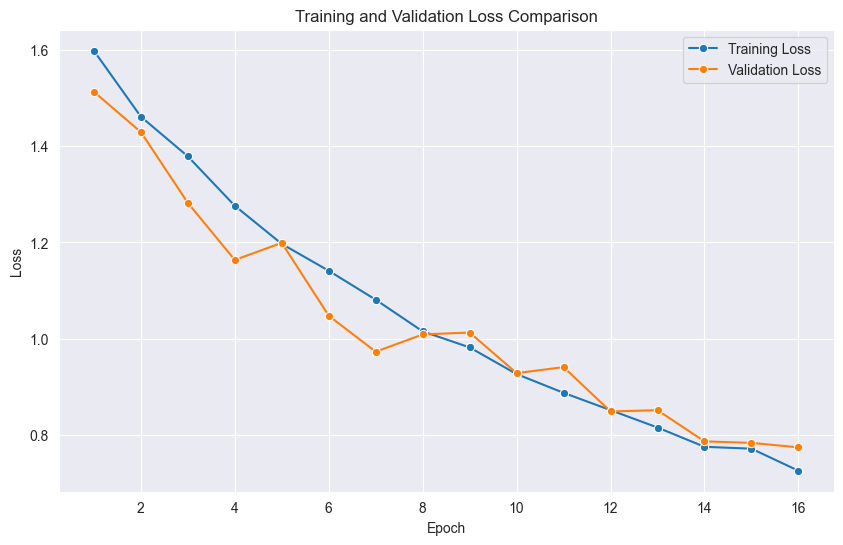

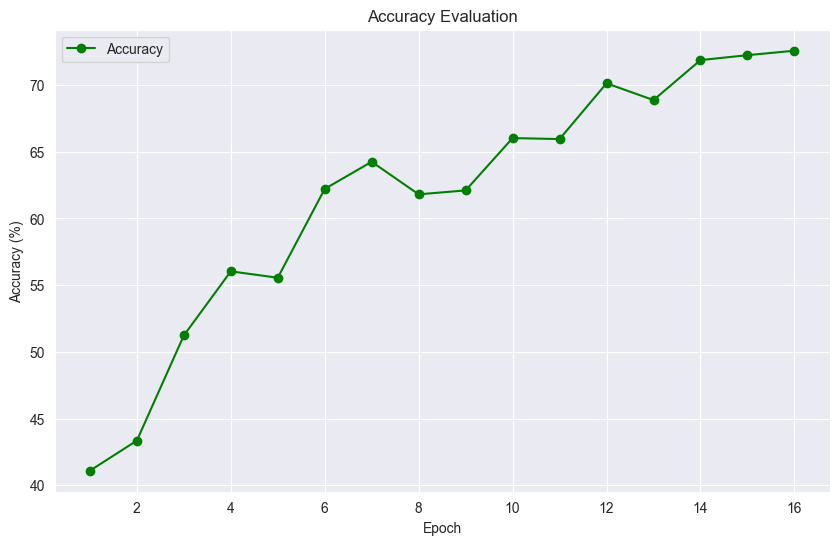

Creating new historical data...
Historical data saved successfully!


In [12]:
from torch.optim import Adam

hardware = torch.device('cuda' if  torch.cuda.is_available() else 'cpu')
classes = 6
criterion = nn.CrossEntropyLoss()
model = PestClassifierResNet50(num_classes=classes).to(hardware)
optimizer = Adam(model.parameters(),lr=1e-4)

result, training_time = train_and_validate(model, optimizer, criterion, train_loader, validation_loader, num_epoch=16, device=hardware)

print(f"Training time: { training_time / 60:.2f} minutes")

plot_training_result(result)
plot_accuracy(result)
save_historical_data(result)
